In [1]:
import Pkg
Pkg.activate("jupyter")
Pkg.instantiate()

Activating environment at `~/LeNet.jl/jupyter/Project.toml`
  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


In [2]:
using Images
using Knet

if Knet.gpu() >= 0
    ATYPE = KnetArray{Float32}
else
    ATYPE = Array{Float32}
end
ATYPE

KnetArray{Float32,N} where N

In [3]:
using LeNet.MNIST

train_images, train_labels, train_scores = train_dataset(padding=2)
test_images, test_labels, test_scores = test_dataset(padding=2)

@show typeof(train_images)
@show size(train_images)
@show typeof(train_labels)
@show size(train_labels)
@show typeof(train_scores)
@show size(train_scores)

┌ Info: Recompiling stale cache file /home/david.lin/.julia/compiled/v1.2/LeNet/7dzcS.ji for LeNet [59d537c7-900a-4367-85e8-51a37eacc432]
└ @ Base loading.jl:1240


typeof(train_images) = PaddedViews.PaddedView{Float16,3,Tuple{Base.OneTo{Int64},Base.OneTo{Int64},Base.OneTo{Int64}},OffsetArrays.OffsetArray{Float16,3,Array{Float16,3}}}
size(train_images) = (32, 32, 60000)
typeof(train_labels) = Array{Int64,1}
size(train_labels) = (60000,)
typeof(train_scores) = Array{Float16,2}
size(train_scores) = (10, 60000)


(10, 60000)

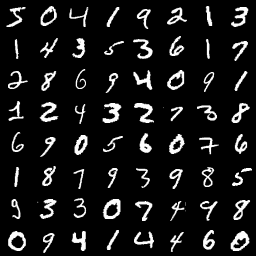

In [4]:
tensor = train_images;
vcat([hcat([tensor[:,:,(i-1)*8+j] .|> Gray for j=1:8]...) for i=1:8]...) |> display

In [5]:
# prepare testing batches
train_data_chk = minibatch(train_images, train_labels, 5000; xtype=ATYPE);
test_data_chk = minibatch(test_images, test_labels, 5000; xtype=ATYPE);

# prepare training batches
train_batches = minibatch(train_images, train_scores, 500; xtype=ATYPE, ytype=ATYPE);
num_batches = div(size(train_images,3), 500)

120

In [6]:
using LeNet, IterTools, Printf

# new model
model = LeNet5()

LeNet5(P(KnetArray{Float32,4}(5,5,1,6)), P(KnetArray{Float32,4}(1,1,6,1)), P(KnetArray{Float32,4}(5,5,6,16)), P(KnetArray{Float32,4}(1,1,16,1)), P(KnetArray{Float32,4}(5,5,16,120)), P(KnetArray{Float32,4}(1,1,120,1)), P(KnetArray{Float32,2}(84,120)), P(KnetArray{Float32,1}(84)), P(KnetArray{Float32,2}(10,84)), P(KnetArray{Float32,1}(10)))

In [7]:
@show last(model(convert(ATYPE, train_images[:,:,1:1])))

last(model(convert(ATYPE, train_images[:, :, 1:1]))) = K32(10,1)[0.09051789⋯]


10×1 KnetArray{Float32,2}:
 0.09051789 
 0.09824963 
 0.10313971 
 0.097146004
 0.09782959 
 0.10080274 
 0.10544741 
 0.10385446 
 0.10278056 
 0.10023204 

In [8]:
acc_train = [accuracy(x -> last(model(x)), train_data_chk)]
acc_test = [accuracy(x -> last(model(x)), test_data_chk)]

@printf "[Before Training]\n"
@printf "accuracy(train_data) = %f %%\n" acc_train[end]*100
@printf "accuracy(test_data) = %f %%\n" acc_test[end]*100

@printf "[Training...]\n"
#adam(model, ncycle(train_batches, 12); lr=0.001) |> progress!
for (i, dx) in enumerate(fit(model, ncycle(train_batches, 256)) |> progress)
    if i % num_batches == 0
        push!(acc_train, accuracy(x -> last(model(x)), train_data_chk))
        push!(acc_test, accuracy(x -> last(model(x)), test_data_chk))
    end
end

@printf "[After Training]\n"
@printf "accuracy(train_data) = %f %%\n" acc_train[end]*100
@printf "accuracy(test_data) = %f %%\n" acc_test[end]*100
@show length(acc_train)

[Before Training]
accuracy(train_data) = 3.573333 %
accuracy(test_data) = 3.290000 %
[Training...]
┣████████████████████┫ [100.00%, 30720/30720, 09:42/09:42, 52.83i/s] 
[After Training]
accuracy(train_data) = 98.183333 %
accuracy(test_data) = 98.110000 %
length(acc_train) = 257


257

In [9]:
# save model
path = "LeNet5-model.jld2"
save_model(path, model)

using JLD2, FileIO

# save training record
path = "LeNet5-training.jld2"
jldopen(path, "w") do file
    file["lenet5/training/acc_train"] = acc_train
    file["lenet5/training/acc_test"] = acc_test
end

257-element Array{Float64,1}:
 0.0329
 0.398 
 0.6475
 0.6864
 0.7129
 0.7992
 0.8435
 0.8598
 0.8711
 0.8751
 0.8789
 0.884 
 0.8877
 ⋮     
 0.9806
 0.9807
 0.9808
 0.9808
 0.9808
 0.9808
 0.9808
 0.9808
 0.9808
 0.9809
 0.981 
 0.9811